In [177]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [178]:
data = pd.read_csv(r"..\data\Combined_dataset.csv")

# Clean data: Handle missing values and outliers (for simplicity, dropping rows with missing data)
data.dropna(inplace=True)

# Encode categorical variables using LabelEncoder
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'day']
le = LabelEncoder()
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# Normalize numerical features
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'TransactionFrequency', 'Recency', 'AverageTransactionAmount']
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Feature selection: We'll focus on important features for segmentation
features = data[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 
                 'TransactionFrequency', 'Recency', 'AverageTransactionAmount', 'y']]

# Target variable: 'y' is whether the customer churned (1 = churned, 0 = retained)
X = features.drop('y', axis=1)
y = features['y']

# Split data into training and testing sets for simulation purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Implement Real-time Dynamic Clustering using MiniBatchKMeans
We will use MiniBatchKMeans for real-time, incremental clustering. This model will update as new customer data arrives, making it ideal for dynamic segmentation.

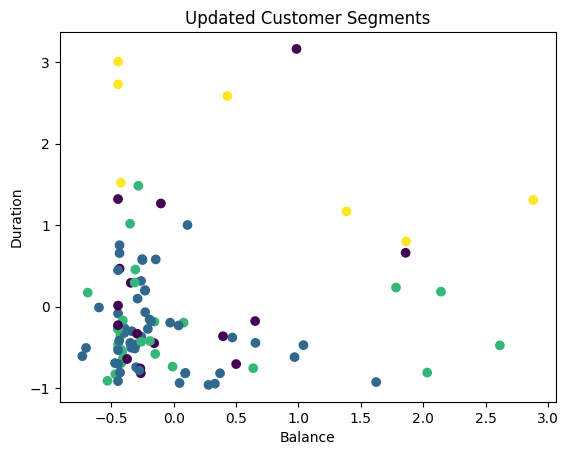

Updated cluster centers after partial fit:
[[-9.91365486e-03 -2.26898435e-02 -8.07906256e-02 -2.24262329e-01
   2.17586224e+00  1.17899272e+00  4.78792015e-03 -9.78649301e-03
  -8.09327488e-03]
 [ 1.37831384e-01 -1.13537935e-01 -2.62473812e-01  1.51493789e-01
  -3.83200283e-01 -2.13903657e-01  2.79536890e-01 -5.58576278e-01
  -9.90112752e-04]
 [-2.74394112e-01 -1.28484093e-01 -1.25988985e-01 -1.09208381e-01
  -3.62404647e-01 -2.01133523e-01 -4.54173409e-01  9.55513995e-01
  -6.41630058e-02]
 [ 2.50958901e-01  1.22433542e+00  2.10545301e+00 -8.18834792e-02
  -2.49568562e-01 -1.11159217e-01 -4.14652668e-02 -1.07074738e-01
   2.46342236e-01]]


In [179]:
#Scaling the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#Initialize MiniBatchKMeans model with 4 clusters
minibatch_kmeans = MiniBatchKMeans(n_clusters=4, random_state=42)

#Fit the model on the initial training data
minibatch_kmeans.fit(X_train_scaled)

# Simulate new data arriving (e.g. 100 samples from X_test)
new_data = X_test.sample(100, random_state=42)

#Scale the new data using the same scaler as for X_train
new_data_scaled = scaler.transform(new_data)

# Predict the clusters for the new data using the fitted model
new_cluster_predictions = minibatch_kmeans.predict(new_data_scaled)

# Update the model with the new data incrementally using partial_fit
minibatch_kmeans.partial_fit(new_data_scaled)

# Add the predicted clusters to the new data
new_data['cluster'] = new_cluster_predictions

# Visualize the updated clusters using balance vs. duration
plt.scatter(new_data['balance'], new_data['duration'], c=new_data['cluster'], cmap='viridis')
plt.title('Updated Customer Segments')
plt.xlabel('Balance')
plt.ylabel('Duration')
plt.show()

# Print the updated cluster centers
print("Updated cluster centers after partial fit:")
print(minibatch_kmeans.cluster_centers_)


Predict: Every time new customer data arrives, use predict() to determine which cluster the customer belongs to.

Update: Use partial_fit() to incrementally update the clustering model, allowing it to evolve as new data arrives.

Real-Time: This process allows you to have dynamic, real-time customer segmentation that adapts to changing customer behavior.

### Simulating the Impact of Marketing Effectiveness and Customer Satisfaction

Once we have the customer segments, we can simulate how marketing campaigns might affect customer satisfaction based on these segments. For example, high-value customers might be more responsive to certain offers, and low-engagement customers might need more targeted interventions.

Simulating Marketing Campaign Effectiveness
We will simulate marketing campaigns targeting different customer segments. We will assume that the effectiveness of a marketing campaign varies by segment and impacts customer satisfaction.

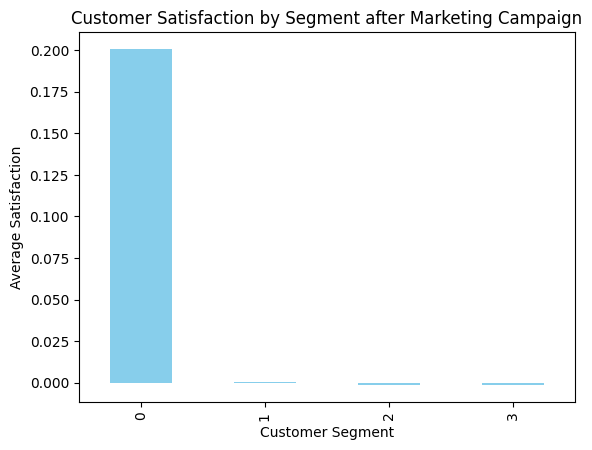

Average Satisfaction by Segment:
cluster
0    0.200783
1    0.000212
2   -0.001458
3   -0.001184
Name: new_satisfaction, dtype: float64


In [180]:
def apply_marketing_campaign(data, campaign_effectiveness=0.2):
    # Ensure 'cluster' exists in the dataset (from the previous clustering step)
    if 'cluster' not in data.columns:
        raise ValueError("'cluster' column not found in the dataset.")
    
    # Simulate a simple rule where high-value customers (cluster 0) have a higher chance of responding to campaigns
    data['marketing_response'] = np.where(data['cluster'] == 0, 1, 0)  # Assume segment 0 (high-value) responds better
    
    # Simulate customer satisfaction change based on response
    data['satisfaction_change'] = data['marketing_response'] * campaign_effectiveness
    return data

# Apply marketing to the customer segments
# Ensure 'cluster' column is present in X_train
if 'cluster' not in X_train.columns:
    X_train['cluster'] = minibatch_kmeans.predict(scaler.transform(X_train))

# Apply marketing campaign
X_train = apply_marketing_campaign(X_train)

# Simulate customer satisfaction post-campaign (increase in satisfaction for those targeted)
X_train['new_satisfaction'] = X_train['satisfaction_change'] + np.random.normal(0, 0.1, size=len(X_train))

# Analyze how satisfaction has changed for each segment
segment_satisfaction = X_train.groupby('cluster')['new_satisfaction'].mean()

# Plot satisfaction by segment
segment_satisfaction.plot(kind='bar', color='skyblue')

plt.title('Customer Satisfaction by Segment after Marketing Campaign')
plt.xlabel('Customer Segment')
plt.ylabel('Average Satisfaction')
plt.show()

# Print the segment satisfaction to check the values
print("Average Satisfaction by Segment:")
print(segment_satisfaction)


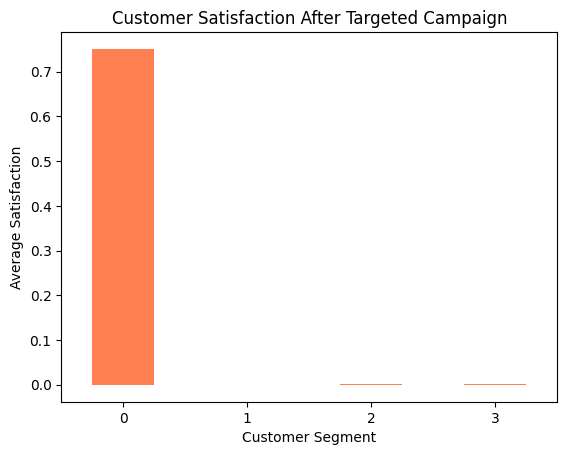

Average Satisfaction by Segment:
cluster
0    0.751046
1   -0.000392
2    0.000594
3    0.001888
Name: new_satisfaction, dtype: float64


In [181]:
# Simulate the effectiveness of marketing based on different campaigns targeting different segments
def campaign_effectiveness(data, target_segment, response_rate=0.3):
    # Increase effectiveness for targeted segments
    data['effective_campaign'] = np.where(data['cluster'] == target_segment, response_rate, 0)
    data['marketing_response'] += data['effective_campaign']
    data['satisfaction_change'] = data['marketing_response'] * response_rate  # Can change response_rate logic for realism
    return data

# Simulate a targeted campaign for segment 0 (high-value customers)
X_train = campaign_effectiveness(X_train, target_segment=0, response_rate=0.5)

X_train['new_satisfaction'] = np.round(X_train['satisfaction_change'] + np.random.normal(0, 0.1, size=len(X_train)), 2)


# Evaluate the campaign effectiveness: Compare satisfaction increase for the target segment vs others
segment_satisfaction_post_campaign = X_train.groupby('cluster')['new_satisfaction'].mean()


segment_satisfaction_post_campaign.plot(kind='bar', color='coral')

plt.title('Customer Satisfaction After Targeted Campaign')
plt.xlabel('Customer Segment')
plt.ylabel('Average Satisfaction')
plt.xticks(rotation=0)
plt.show()

# Print the segment satisfaction to check the values
print("Average Satisfaction by Segment:")
print(segment_satisfaction_post_campaign)

These bar chart illustrates the **average customer satisfaction** following a marketing campaign and **average customer satisfaction by segment after a targeted marketing campaign** across different customer segments (labeled 0, 1, 2, and 3). 
1. **High Satisfaction in Segment 0**:
   - indicating that the marketing campaign resonated well with this group. It’s possible that Segment 0 represents customers with certain characteristics or behaviors that align with the campaign's messaging or offers.
   - the targeted campaign also effectively resonated with this group. Segment 0 might represent customers who align well with the campaign's offers or messaging.
2. **Minimal Impact on Segments 1, 2, and 3**:
   - very low satisfaction levels in Segments 1, 2, and 3 suggest that the *marketing campaign* had little to no positive impact on these groups. This discrepancy could indicate that the campaign content was not relevant or appealing to customers in these segments. 
   - very low satisfaction levels suggest that the *targeted campaign* had little impact on them. This difference could indicate that these segments were either uninterested in the campaign or did not respond well to its approach.

**Possible Reasons for Disparity**:
   - **Targeting Mismatch**: The campaign might have been tailored more for Segment 0, leaving the other segments unengaged. Understanding the differences in preferences, needs, or behaviors of these segments could help tailor future campaigns better.
   - **Segment Differences**: There may be fundamental behavioral or demographic differences between Segment 0 and the other segments. For example, Segment 0 could consist of more active or engaged customers who are responsive to marketing efforts, whereas the other segments might have lower engagement levels overall.

This result highlights the importance of customer segmentation in marketing and suggests that a one-size-fits-all approach may not work for all segments. Personalized marketing strategies based on segment characteristics could lead to improved satisfaction across the board.

In [182]:
# Initialize 'initial_satisfaction' column with a baseline satisfaction value (e.g., 0)
X_train['initial_satisfaction'] = 0

# Evaluate the overall satisfaction change after the campaign
overall_satisfaction_change = X_train['new_satisfaction'].mean() - X_train['initial_satisfaction'].mean()
print(f"Overall customer satisfaction change after the marketing campaign: {overall_satisfaction_change:.2f}")


Overall customer satisfaction change after the marketing campaign: 0.10
